In [1]:
import sys
sys.path.append('..')

In [2]:
from nbhd import data

In [3]:
db = data.Base()

Initializing database connection...
Database connected!


In [4]:
britain = db.query('SELECT * FROM isles LIMIT 1', spatial=True)

<AxesSubplot:>

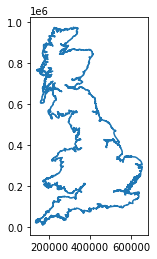

In [5]:
britain.geometry.boundary.plot()

In [6]:
# db.query('''ALTER TABLE roads
#          RENAME COLUMN "roadFunction" to road_function;''')

In [7]:
db.info('roads')

,Column,Datatype
0,id,text
1,endNode,text
2,startNode,text
3,roadNumberTOID,text
4,roadNameTOID,text
5,fictitious,boolean
6,roadClassification,text
7,road_function,text
8,formOfWay,text
9,length,bigint


In [30]:
# impot pandas as pd
# road_functions = db.distinct('road_function', 
#                              'roads').road_function.values

# counts = {}
# for rf in road_functions:
#     counts[rf] = db.query(f'''
#     SELECT COUNT(*) FROM roads 
#     WHERE road_function LIKE '{rf}'
#     ''')['count'][0]

# pd.DataFrame(counts, index=['counts']).T

In [ ]:
# function added to nbhd.data.Base
road_counts = db.count('roads', 'road_function')

In [35]:
local_roads =db.query('''
select split_part(name1, ' ', 2)  AS name_ending,
        geometry
       FROM roads WHERE road_function LIKE 'Local Road'
''', spatial=True)

In [38]:
name_counts = local_roads.value_counts('name_ending')

In [50]:
df = name_counts.loc[name_counts>1000].reset_index()

In [55]:
df.loc[df.name_ending!='']

,name_ending,0
0,Road,334653
1,Street,142496
2,Close,136917
3,Avenue,127178
4,Drive,107196
5,Way,72411
6,Lane,69680
8,Crescent,46360
9,Gardens,32574
10,Place,28331
